In [86]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from tensorflow.keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras import layers
# import tensorflow_addons as tfa
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split

In [2]:
#加载数据

In [56]:
mat_file = sio.loadmat('F:/柔灵科技/情绪/ExtractedFeatures/ExtractedFeatures/DE_data_all_corrected.mat')
mat_file_labels = sio.loadmat('F:/柔灵科技/情绪/ExtractedFeatures/ExtractedFeatures/label.mat')
count = 0
accuracy = []

In [57]:
type(mat_file)

dict

In [63]:
data = mat_file['data']

In [64]:
type(data)

numpy.ndarray

In [65]:
data.shape #675个数据，62个导联，265x5 它代表了一个非线性特征组 

(675, 62, 265, 5)

In [66]:
#打标签，制作label

In [67]:
labels = mat_file_labels['label'] 

In [68]:
labels

array([[ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1]],
      dtype=int16)

In [69]:
labels = labels[0]

In [70]:
labels_edited = np.empty(675)

In [71]:
for i in range(0,45):
  labels_edited[i*15:(i+1)*15] = labels

In [72]:
#data和 label 要对应，data(0) 和label(0)要对应，data(0)代表伤心的数据 label(0) -1 1 

In [73]:
#shuffle函数 [01-1010-101000]

In [74]:
data, labels_edited = shuffle(data, labels_edited)

In [75]:
#45x28x28x3  45

In [76]:
data.shape

(675, 62, 265, 5)

In [77]:
labels_edited.shape

(675,)

In [78]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)

In [79]:
data_max = np.max(data)

In [80]:
#提取两类数据

In [81]:
train_data = []
train_label = []
for i,j in zip(data,labels_edited):
    if j == 1.0:
        continue
    train_data.append(i)
    train_label.append(j)

In [82]:
#把列表转为数组

In [83]:
data = np.asarray(train_data)
labels_edited = np.asarray(train_label)

In [84]:
data = data[:,:,0:250,:]

In [ ]:
#划分训练集和测试集  100组数据  100组label  80个数据做训练 20个数据做测试

In [90]:
data.shape

(450, 62, 250, 5)

In [89]:
labels_edited.shape

(450,)

In [87]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels_edited,test_size=0.2,random_state=1234)

In [91]:
train_data.shape

(360, 62, 250, 5)

In [88]:
train_labels.shape

(360,)

In [ ]:
#凑卷积数据格式 [2] 1 1X1

In [92]:
train_labels_reshaped = train_labels.reshape(-1,1)
test_labels_reshaped = test_labels.reshape(-1,1)

In [93]:
#ONE HOT 编码格式 word embedding

In [94]:
train_labels_reshaped1 = to_categorical(train_labels_reshaped, 2) #One Hot Encoding
test_labels_reshaped1 = to_categorical(test_labels_reshaped, 2)

In [ ]:
#8-13Hz 

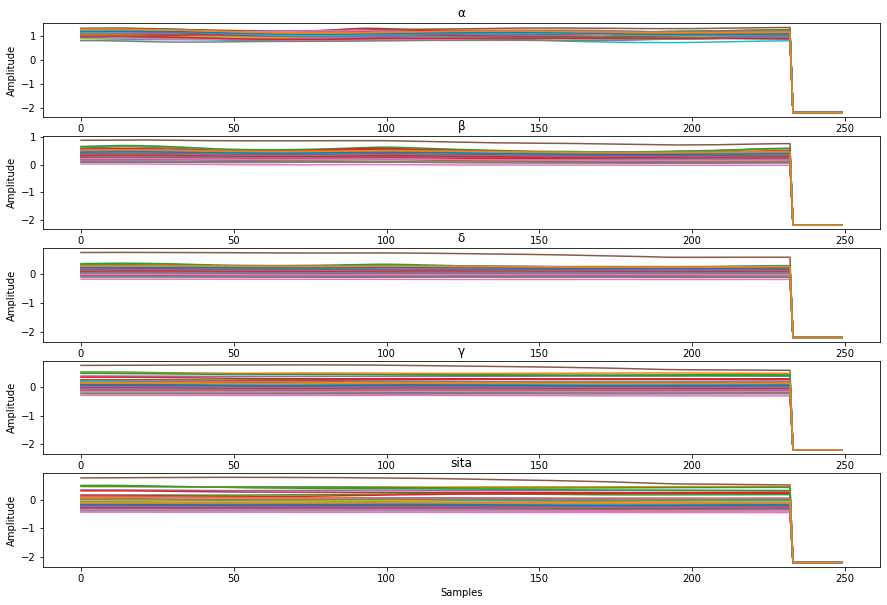

In [95]:
fig, a = plt.subplots(5, 1, squeeze= False, figsize= (15, 10))
titles = ['α', 'β', 'δ', 'γ', 'sita']
for cnt in range(5):
  for i in range(len(test_data[5])):
    a[cnt][0].plot(range(len(test_data[5][i,:,cnt])), test_data[5][i,:,cnt])
  a[cnt][0].set_title(titles[cnt])
  a[cnt][0].set_xlabel('Samples')
  a[cnt][0].set_ylabel('Amplitude')

In [ ]:
#tf-gpu 2.0 CRNN  
#softmax [0,-1]
#       [0.8,0.2]

In [54]:
#Defining our Hybrid model 
model_hybrid = Sequential([
  Conv2D(filters= 64, kernel_size= 3, input_shape = (62,250,5), padding= 'same'), 
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  BatchNormalization(),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), 
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  BatchNormalization(),

  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), 
  BatchNormalization(),
 #（15, 62, 512) 
  Reshape((62, 15*512), input_shape= (15, 62, 512)), #Important to reshape so data passed to LSTM Layer correctly
  
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 512, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  
  Flatten(),
  
  Dense(512, activation= 'relu'), 
  Dropout(0.25), 
  Dense(256, activation= 'relu'),
  Dropout(0.2),
  Dense(64, activation= 'relu'),
  Dense(2, activation= 'softmax')
])

model_hybrid.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model_hybrid.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 250, 64)       2944      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 250, 128)      73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 250, 128)      147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 125, 128)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 125, 128)      512       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 125, 256)      295168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 125, 256)     

In [36]:
#Training our Hybrid model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_hybrid = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9

history_hybrid = model_hybrid.fit(
  train_data,
  train_labels_reshaped1,
  batch_size = 32,
  epochs=60,
  validation_data=(test_data, test_labels_reshaped1),
  callbacks = [reduce_lr_hybrid]
)

Train on 360 samples, validate on 90 samples
Epoch 1/60
360/360 [==============================] - 41s 114ms/sample - loss: 2.3433 - accuracy: 0.5500 - root_mean_squared_error: 0.6190 - val_loss: 0.6884 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.4976
Epoch 2/60
360/360 [==============================] - 30s 83ms/sample - loss: 0.9678 - accuracy: 0.7139 - root_mean_squared_error: 0.4914 - val_loss: 0.6868 - val_accuracy: 0.4889 - val_root_mean_squared_error: 0.4965
Epoch 3/60
360/360 [==============================] - 28s 77ms/sample - loss: 1.0547 - accuracy: 0.7000 - root_mean_squared_error: 0.4936 - val_loss: 0.7511 - val_accuracy: 0.4889 - val_root_mean_squared_error: 0.5237
Epoch 4/60
360/360 [==============================] - 29s 82ms/sample - loss: 1.1374 - accuracy: 0.7139 - root_mean_squared_error: 0.4861 - val_loss: 0.7191 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.5138
Epoch 5/60
360/360 [==============================] - 30s 82ms/sample - loss: 1.05

In [ ]:
#CNN

In [75]:
conv_block_trial = Sequential([
  
  Conv2D(filters= 128, kernel_size= 3, input_shape = (62,250,5), padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.3),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  Dropout(rate= 0.2),


  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = (1,2)),
    Flatten(),
    Dense(128,activation='relu'),
  Dropout(rate= 0.25),
    Dense(64, activation= 'relu'),
  Dense(2, activation= 'softmax')
])
conv_block_trial.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
conv_block_trial.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 62, 250, 128)      5888      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 62, 250, 128)      147584    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 31, 125, 128)      0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 31, 125, 128)      0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 31, 125, 256)      295168    
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 31, 125, 256)      590080    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 15, 62, 256)     

In [ ]:
history = conv_block_trial.fit(
  train_data,
  train_labels_reshaped1,
  batch_size = 32,
  epochs=50, 
  validation_data=(test_data, test_labels_reshaped1)
)

Train on 360 samples, validate on 90 samples
Epoch 1/50
360/360 [==============================] - 13s 35ms/sample - loss: 95.7977 - accuracy: 0.4889 - root_mean_squared_error: 0.6918 - val_loss: 177.4807 - val_accuracy: 0.5444 - val_root_mean_squared_error: 0.6750
Epoch 2/50
360/360 [==============================] - 13s 37ms/sample - loss: 110.3853 - accuracy: 0.5000 - root_mean_squared_error: 0.7073 - val_loss: 11.9985 - val_accuracy: 0.5111 - val_root_mean_squared_error: 0.6908
Epoch 3/50
360/360 [==============================] - 15s 41ms/sample - loss: 28.1219 - accuracy: 0.5333 - root_mean_squared_error: 0.6800 - val_loss: 12.9761 - val_accuracy: 0.4889 - val_root_mean_squared_error: 0.7134
Epoch 4/50
360/360 [==============================] - 16s 45ms/sample - loss: 21.3030 - accuracy: 0.5306 - root_mean_squared_error: 0.6782 - val_loss: 13.7326 - val_accuracy: 0.5111 - val_root_mean_squared_error: 0.6850
Epoch 5/50
360/360 [==============================] - 17s 47ms/sample - l

360/360 [==============================] - 23s 63ms/sample - loss: 0.1957 - accuracy: 0.8778 - root_mean_squared_error: 0.2580 - val_loss: 0.3322 - val_accuracy: 0.9111 - val_root_mean_squared_error: 0.2343
Epoch 39/50
360/360 [==============================] - 22s 62ms/sample - loss: 0.1863 - accuracy: 0.8944 - root_mean_squared_error: 0.2532 - val_loss: 0.2613 - val_accuracy: 0.9111 - val_root_mean_squared_error: 0.2336
Epoch 40/50
360/360 [==============================] - 23s 63ms/sample - loss: 0.1898 - accuracy: 0.8833 - root_mean_squared_error: 0.2584 - val_loss: 0.7652 - val_accuracy: 0.8889 - val_root_mean_squared_error: 0.2234
Epoch 41/50
360/360 [==============================] - 23s 65ms/sample - loss: 0.1874 - accuracy: 0.8778 - root_mean_squared_error: 0.2567 - val_loss: 1.0520 - val_accuracy: 0.9444 - val_root_mean_squared_error: 0.2255
Epoch 42/50
360/360 [==============================] - 23s 65ms/sample - loss: 0.1784 - accuracy: 0.8722 - root_mean_squared_error: 0.24

In [ ]:
#maen:88% std:2%    88%±2%

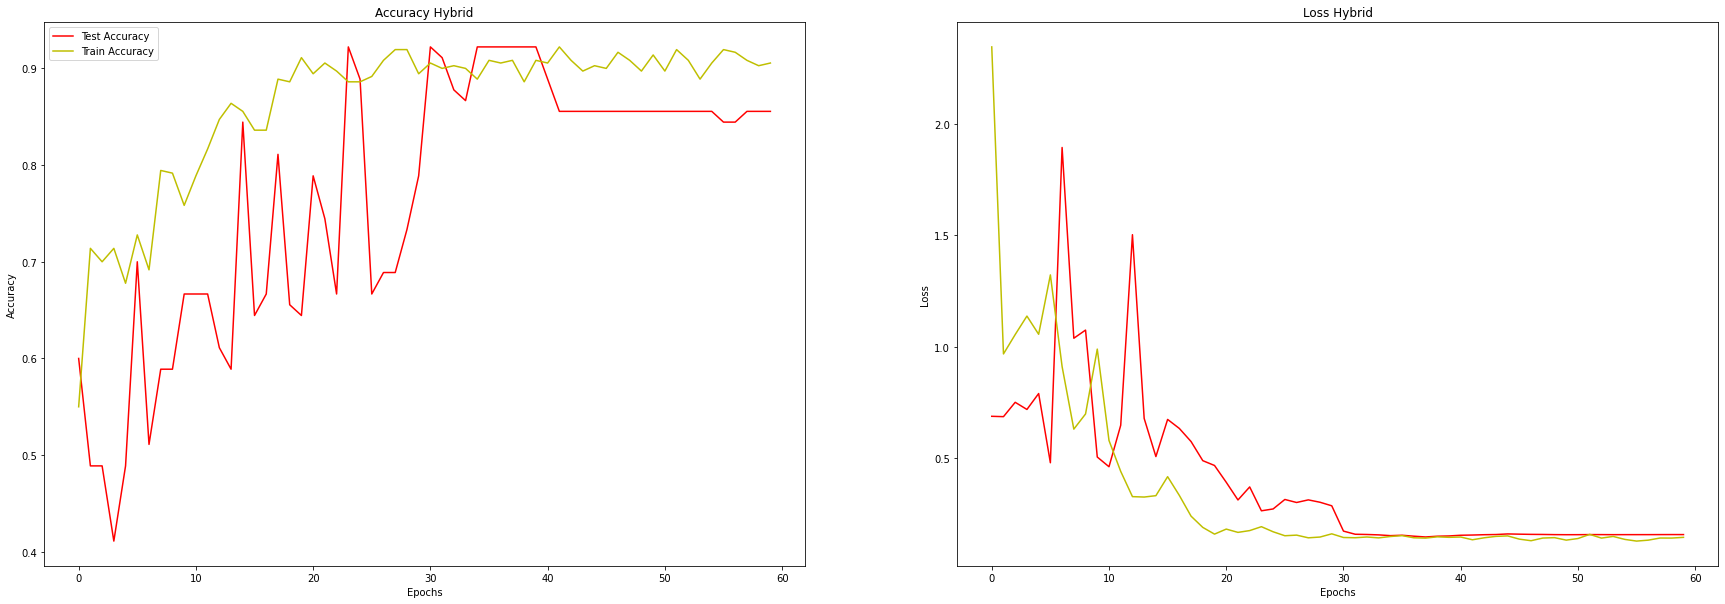

In [37]:
import matplotlib.pyplot as plt

epochs_hybrid = len(history_hybrid.history['accuracy'])

plt.rcParams["figure.figsize"] = (30,10)
fig, a = plt.subplots(1, 2, squeeze= False)
a[0][1].plot(range(0,epochs_hybrid), history_hybrid.history['val_loss'], 'r', label = 'Test Loss')
a[0][1].plot(range(0,epochs_hybrid), history_hybrid.history['loss'], 'y', label = 'Train Loss')
a[0][1].set_title('Loss Hybrid')
a[0][1].set_xlabel('Epochs')
a[0][1].set_ylabel('Loss')

a[0][0].plot(range(0,epochs_hybrid), history_hybrid.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs_hybrid), history_hybrid.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy Hybrid')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Accuracy')
a[0][0].legend()
a[0][0].legend()

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens,#这个地方设置混淆矩阵的颜色主题，这个主题看着就干净~
                          normalize=True):
   
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

In [40]:
def plot_confuse(model, x_val, y_val):
    predictions = model.predict_classes(x_val,batch_size=32)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=False,target_names=labels,title='Confusion Matrix')

In [41]:
import itertools

In [ ]:
#TP  FN FP TN 写在论文中

<Figure size 2160x720 with 0 Axes>

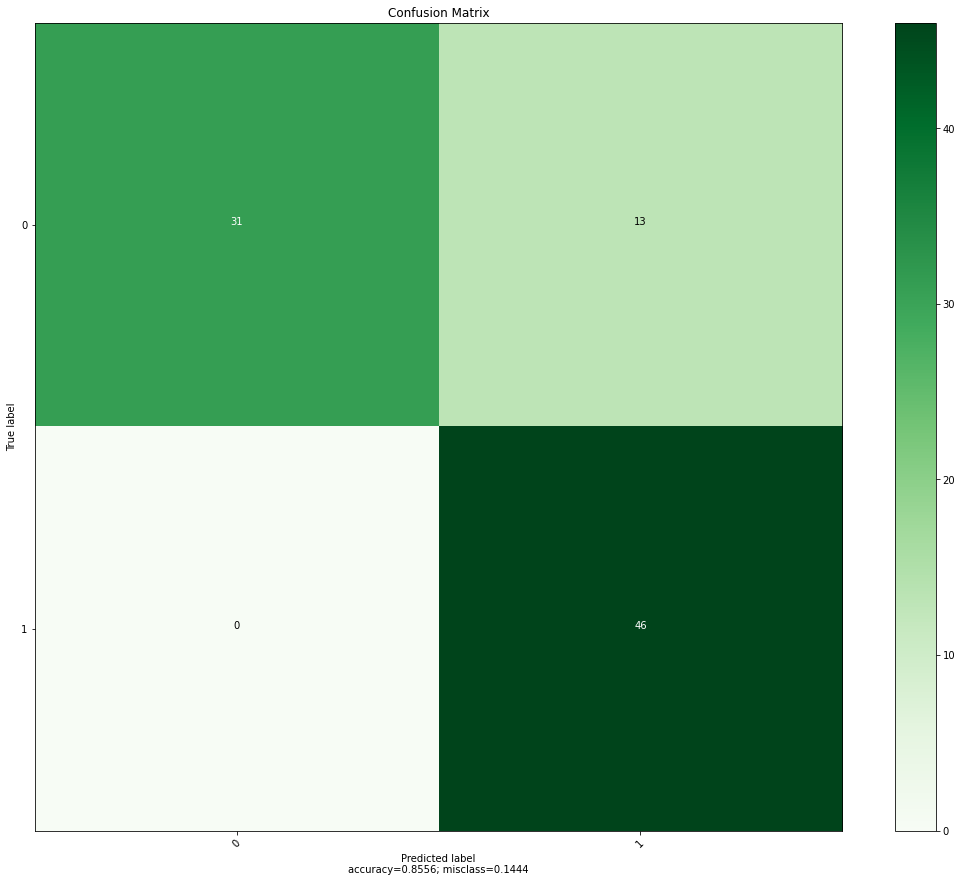

In [43]:
labels=['0','1']
plot_confuse(model_hybrid, test_data,test_labels_reshaped)